In [1]:
import pickle
import multidms
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines

In [2]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [3]:
OUTDIR = "results/ch_collapsed_barcodes/"
# title = "Shrinkage Analysis of $C_{d}$ Models, \nbarcodes NOT collapsed"
title = "Shrinkage Analysis"

In [4]:
# models = pickle.load(open("old-notebooks/gamma-noch-models.pkl", "rb"))
# models = pickle.load(open("old-notebooks/ch-nogamma-models.pkl", "rb"))
models = pickle.load(open(f"{OUTDIR}/models.pkl", "rb"))


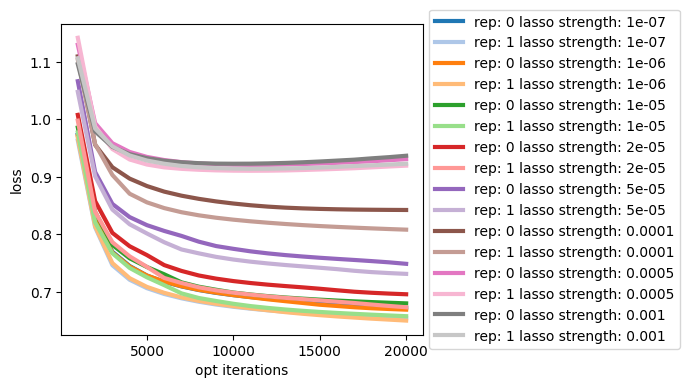

In [5]:
cmap=plt.get_cmap("tab20")


fig, ax = plt.subplots(1,figsize=[7,4])
for i, (model, model_row) in enumerate(models.iterrows()):
    ax.plot(
        [1000 * (s+1) for s in range(len(model_row.step_loss))],
        model_row.step_loss,
        c=cmap.colors[i],
        lw=3,
        label=f"rep: {model_row.replicate} lasso strength: {model_row.λ_lasso_shift}"
    )

ax.set_ylabel("loss")
ax.set_xlabel("opt iterations")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [6]:
models

,dataset,δ_huber,λ_lasso_shift,λ_ridge_beta,λ_ridge_shift,λ_ridge_gamma,data_idx,epistatic_model,output_activation,lock_beta,...,init_C_ref,warmup_beta,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_20000,replicate
0,<multidms.data.MultiDmsData object at 0x7f7c3b...,1,0.0,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[0.9733555409201907, 0.8280141208921765, 0.769...",<multidms.model.MultiDmsModel object at 0x7f79...,0
1,<multidms.data.MultiDmsData object at 0x7f7c30...,1,0.0,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[0.9632855593783072, 0.8125650438953164, 0.746...",<multidms.model.MultiDmsModel object at 0x7f79...,1
2,<multidms.data.MultiDmsData object at 0x7f7c3b...,1,0.000001,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[0.9710215537922314, 0.8282119836919564, 0.768...",<multidms.model.MultiDmsModel object at 0x7f7c...,0
3,<multidms.data.MultiDmsData object at 0x7f7c30...,1,0.000001,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[0.9681033233951882, 0.8144748418296023, 0.750...",<multidms.model.MultiDmsModel object at 0x7f79...,1
4,<multidms.data.MultiDmsData object at 0x7f7c3b...,1,0.00001,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[0.9857248012386187, 0.8392299475448087, 0.781...",<multidms.model.MultiDmsModel object at 0x7f79...,0
5,<multidms.data.MultiDmsData object at 0x7f7c30...,1,0.00001,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[0.9772368335591555, 0.8210960572132471, 0.767...",<multidms.model.MultiDmsModel object at 0x7f79...,1
6,<multidms.data.MultiDmsData object at 0x7f7c3b...,1,0.00002,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.0077470996595188, 0.8581141011300257, 0.802...",<multidms.model.MultiDmsModel object at 0x7f79...,0
7,<multidms.data.MultiDmsData object at 0x7f7c30...,1,0.00002,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[0.9976864788836723, 0.8394673062243602, 0.786...",<multidms.model.MultiDmsModel object at 0x7f79...,1
8,<multidms.data.MultiDmsData object at 0x7f7c3b...,1,0.00005,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.0662709917105295, 0.908607495860237, 0.8530...",<multidms.model.MultiDmsModel object at 0x7f79...,0
9,<multidms.data.MultiDmsData object at 0x7f7c30...,1,0.00005,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.047649042817643, 0.9012415576140917, 0.8433...",<multidms.model.MultiDmsModel object at 0x7f79...,1


In [11]:
lasso_cmap=plt.get_cmap("Set2").colors
lasso_shrinkage = sorted(models.λ_lasso_shift.unique())
lasso_shrinkage_cmap = dict(zip(lasso_shrinkage, lasso_cmap))
mutations_to_highlight = ["D142L", "A419S", "A570D", "K854N", "T1027I"]
mutations_cmap=plt.get_cmap("Accent").colors
mutations_cmap = dict(zip(mutations_to_highlight, mutations_cmap))
times_seen_threshold = 3
model_name = "model_20000"

In [12]:
# plt.rcParams['axes.grid'] = False

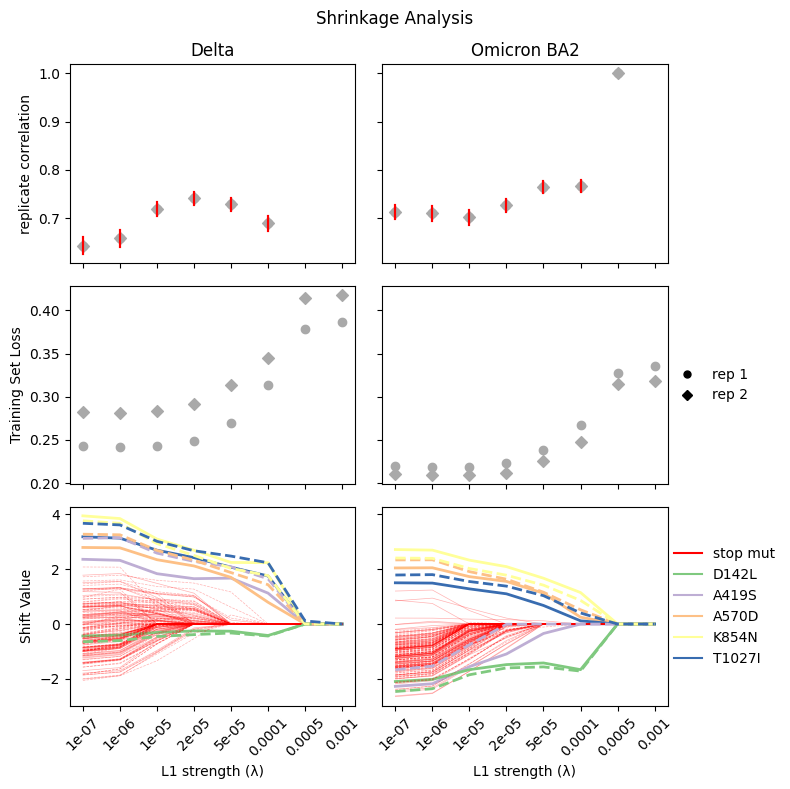

In [13]:
fig, ax = plt.subplots(3,2, figsize=[8,8],sharex=True, sharey='row')
# plt.rcParams['axes.grid'] = True

# t_points = np.linspace(0, 2.5, 100)
# def perc_abs_lte(x, t):
#     abs_x = np.abs(x)
#     return len(abs_x[abs_x<=t]) / len(x)

# TODO this could be a good method for the object.
def loss(model, condition):
    kwargs = {
        'λ_ridge_beta': 0.,
        'λ_ridge_shift': 0.,
        'λ_ridge_gamma': 0.
    }
    
    data = (
        {condition:model.data.training_data["X"][condition]}, 
        {condition:model.data.training_data["y"][condition]}
    )
    
    params = model.get_condition_params(condition)
    # https://github.com/matsengrp/multidms/issues/65
#     print(params)
#     params["β"] = params["β_m"]

    return model._model_components["objective"](model.params, data)


for lasso, lasso_replicates in models.groupby("λ_lasso_shift"):
    
    fit_dict = {}
    for _, row in lasso_replicates.iterrows():
        model = row[model_name]
        replicate = row.replicate
        fit_dict[f"{replicate}"] = model

    muts_df_outer = multidms.utils.combine_replicate_muts(
        fit_dict, 
        times_seen_threshold=times_seen_threshold, 
        how="outer"
    )
    muts_df_inner = muts_df_outer.dropna()
    
    # plot corr by sparsity
    for cond in model.data.conditions:
        if cond == model.data.reference: continue
        axes = ax[0, 0] if cond == "Delta" else ax[0, 1]
        if np.all(muts_df_inner[f"0_S_{cond}"] == 0) or np.all(muts_df_inner[f"1_S_{cond}"] == 0):
            continue
        corr = pearsonr(muts_df_inner[f"0_S_{cond}"], muts_df_inner[f"1_S_{cond}"])
        r = corr[0]
        interval = corr.confidence_interval()
#         print(interval.low)
#         break
#     break
    
        
        
        for rep, marker in zip([0,1], ["o", "D"]):
            rep_cond_shifts = muts_df_outer[f"{rep}_S_{cond}"]
            sparsity = len(rep_cond_shifts[rep_cond_shifts==0]) / len(rep_cond_shifts)
#             axes.scatter(sparsity,corr, marker=marker, color=lasso_shrinkage_cmap[lasso])
#             axes.scatter(str(lasso),corr, marker=marker, color=lasso_shrinkage_cmap[lasso])
            axes.scatter(str(lasso),r, marker=marker, color="darkgrey")
            axes.plot([str(lasso), str(lasso)], [interval.low, interval.high], color="red")
            
    # plot mae 
    for _, row in lasso_replicates.iterrows():
        model = row[model_name]
        replicate = row.replicate
        marker = "o" if replicate ==0 else "D"
        for cond in model.data.conditions:
            if cond == model.data.reference: continue
            axes = ax[1, 0] if cond == "Delta" else ax[1, 1]
            
#             rep_cond_shifts = model.mutations_df[f"S_{cond}"]
#             sparsity = len(rep_cond_shifts[rep_cond_shifts==0]) / len(rep_cond_shifts)
            
            vdf = model.variants_df.query("condition == @cond")
#             mae = np.sum(np.abs(vdf.predicted_func_score - vdf.corrected_func_score))/len(vdf)
#             mae = np.sum(np.abs(vdf.predicted_func_score - vdf.corrected_func_score)**2)/len(vdf)
            
#             loss(model, cond)

#             axes.scatter(sparsity,mae, marker=marker, color=lasso_shrinkage_cmap[lasso])
#             axes.scatter(str(lasso),mae, marker=marker, color=lasso_shrinkage_cmap[lasso])
            axes.scatter(str(lasso),loss(model, cond), marker=marker, color="darkgrey")
            
            
#             break
#         break
#     break
            
            
#     plot percentage of shifts < t
#     for cond in model.data.conditions:
#         if cond == model.data.reference: continue
#         axes = ax[1, 0] if cond == "Delta" else ax[1, 1]
#         for rep, style in zip([0,1], ["-", "--"]):
#             rep_cond_shifts = muts_df_outer[f"{rep}_S_{cond}"]
#             lt_percentages = [perc_abs_lte(rep_cond_shifts, t) for t in t_points]
#             axes.plot(t_points, lt_percentages, color=lasso_shrinkage_cmap[lasso], linestyle=style)
    
            
ax[0,0].set_ylabel("replicate correlation")
# ax[0,0].set_xlabel("model sparsity (%S == 0)")
# ax[0,1].set_xlabel("model sparsity (%S == 0)")
ax[0, 0].set_title("Delta")
ax[0, 1].set_title("Omicron BA2")
# ax[1,0].set_ylabel("Fraction of Shift \nParameters with values <= x")
ax[1,0].set_ylabel("Training Set Loss")
# ax[1,0].set_xlabel("Shift Value")
# ax[1,1].set_xlabel("Shift Value")
# ax[0, 0].get_shared_y_axes().join(ax[0, 0], ax[0, 1])
# ax[2, 0].get_shared_y_axes().join(ax[2, 0], ax[2, 1])


# elbow plot legend
black_circle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=5, label='rep 1')
black_triangle = mlines.Line2D([], [], color='black', marker='D', linestyle='None',
                          markersize=5, label='rep 2')
# lasso_color_handles = [
#     mlines.Line2D(
#         [], [], 
#         color=color, 
#         linestyle='-',
#         markersize=10,
#         label=f"λ = {lasso}"
#     )
#     for lasso, color in lasso_shrinkage_cmap.items()
# ]
elements = [black_circle, black_triangle] #+lasso_color_handles
ax[1, 1].legend(handles=elements, bbox_to_anchor = (1.15, 0.5), loc='center', frameon=False)

# # percent under x legend
# black_line = mlines.Line2D([], [], color='black', linestyle='-',
#                           markersize=5, label='rep 1')
# black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
#                           markersize=5, label='rep 2')
# elements = [black_line, black_dashed]
# ax[1, 1].legend(handles=elements, bbox_to_anchor = (1.35, 0.5), loc='center right', frameon=False)


for replicate, rep_models in models.groupby("replicate"):
    fit_dict = {row.λ_lasso_shift:row[model_name] for _, row in rep_models.iterrows()}
    mut_df = multidms.utils.combine_replicate_muts(
        fit_dict, 
        times_seen_threshold=times_seen_threshold, 
        how="outer"
    )

    mut_df = pd.melt(
        mut_df.reset_index(), 
        id_vars=["mutation"],
        value_vars=[
            col for col in mut_df.columns 
            if "_S_" in col and "avg" not in col
        ],
        value_name="S"
    )
    mut_df = mut_df.assign(
        λ_lasso=[ 
            v.split("_")[0]
            for v in mut_df.variable
        ],
        is_stop=[
            True if "*" in mut else False
            for mut in mut_df.mutation
        ],
        condition=[
            "_".join(v.split("_")[2:])
            for v in mut_df.variable
        ]
    )
    
    mut_df.drop("variable", axis=1, inplace=True)
    for condition, condition_muts in mut_df.groupby("condition"):
        axes = ax[2,0] if condition == "Delta" else ax[2,1]
        color, alpha, width ="grey", 0.01, 0.5
        style = "-" if replicate == 0 else "--"
        
#         # plot background traces
#         for mut, trace_df in condition_muts.query(
#             "not is_stop & not mutation.isin(@mutations_to_highlight)"
#         ).groupby("mutation"):
            
#             axes.plot(
#                 trace_df.λ_lasso, 
#                 trace_df.S,
#                 linestyle=style,
#                 linewidth=width,
#                 alpha=alpha,
#                 color=color
#             )
        
        # plot stop traces
        for mut, trace_df in condition_muts.query("is_stop").groupby("mutation"):
            color, alpha="red", 0.3
            axes.plot(
                trace_df.λ_lasso, 
                trace_df.S,
                linestyle=style,
                linewidth=width,
                alpha=alpha,
                color=color
            )
            
        # plot highlighted muts
        for mut, trace_df in condition_muts.query(
            "mutation.isin(@mutations_to_highlight)"
        ).groupby("mutation"):
            color, alpha, width = mutations_cmap[mut], 1.0, 2.0
            axes.plot(
                trace_df.λ_lasso, 
                trace_df.S,
                linestyle=style,
                linewidth=width,
                alpha=alpha,
                color=color
            )

ax[2,0].set_xticks(ax[2,0].get_xticks(), ax[2,0].get_xticklabels(), rotation=45, ha='center')
ax[2,1].set_xticks(ax[2,1].get_xticks(), ax[2,1].get_xticklabels(), rotation=45, ha='center')
ax[2,0].set_ylabel("Shift Value")
ax[2,0].set_xlabel("L1 strength (λ)")
ax[2,1].set_xlabel("L1 strength (λ)")

red_line = mlines.Line2D([], [], color='red', linestyle='-',
                          markersize=1, label='stop mut')
# grey_line = mlines.Line2D([], [], color='grey',  linestyle='-',
#                           markersize=5, label='mutation not validated')
mutation_color_handles = [
    mlines.Line2D(
        [], [], 
        color=color, 
        linestyle='-',
        markersize=10,
        label=f"{mutation}"
    )
    for mutation, color in mutations_cmap.items()
]
# elements = [red_line, grey_line]+mutation_color_handles
elements = [red_line]+mutation_color_handles
ax[2, 1].legend(handles=elements, bbox_to_anchor = (1.2, 0.5), loc='center', frameon=False)


fig.suptitle(title)
plt.tight_layout()
fig.savefig(f"{OUTDIR}/models-summary.pdf")
plt.show()

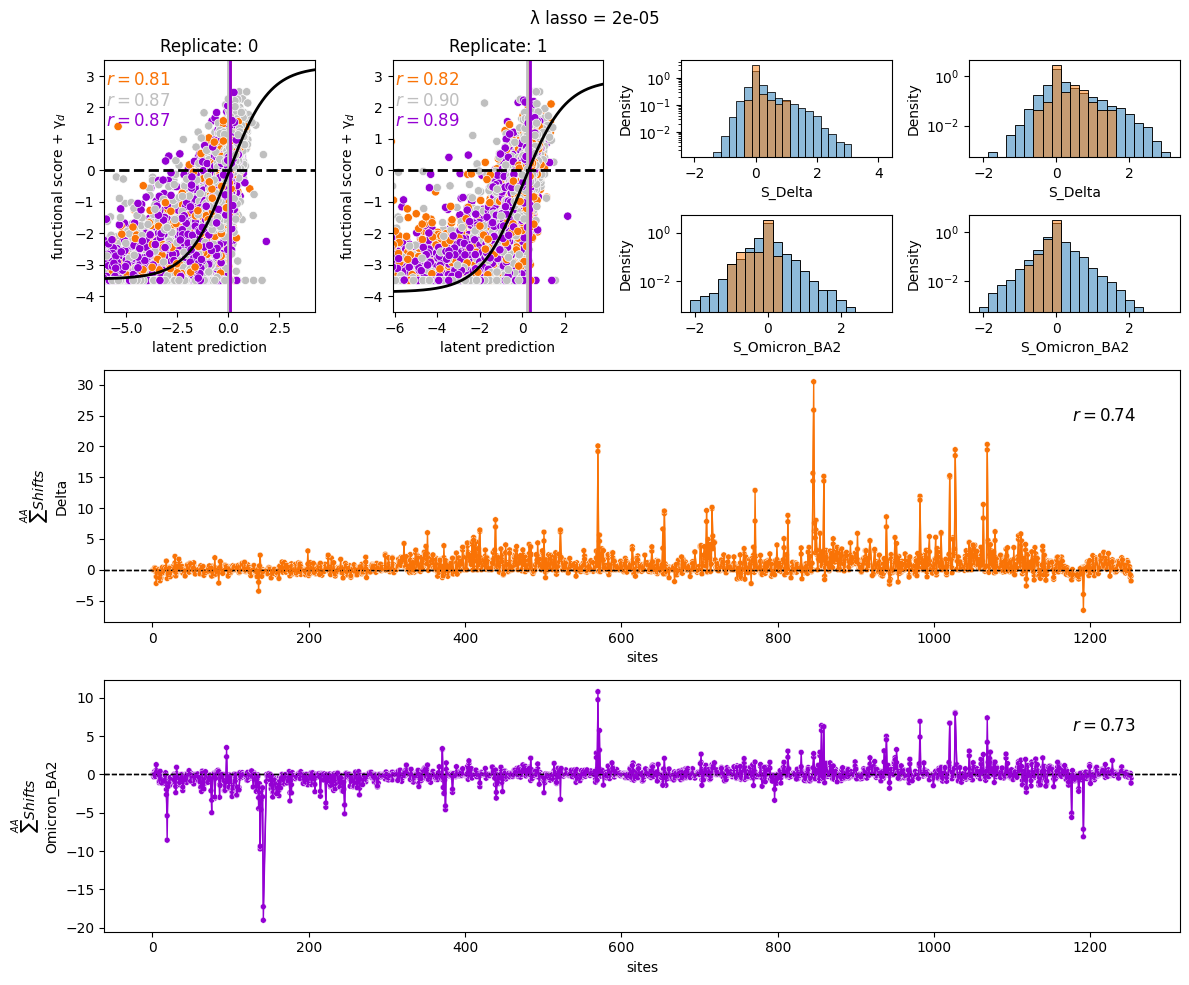

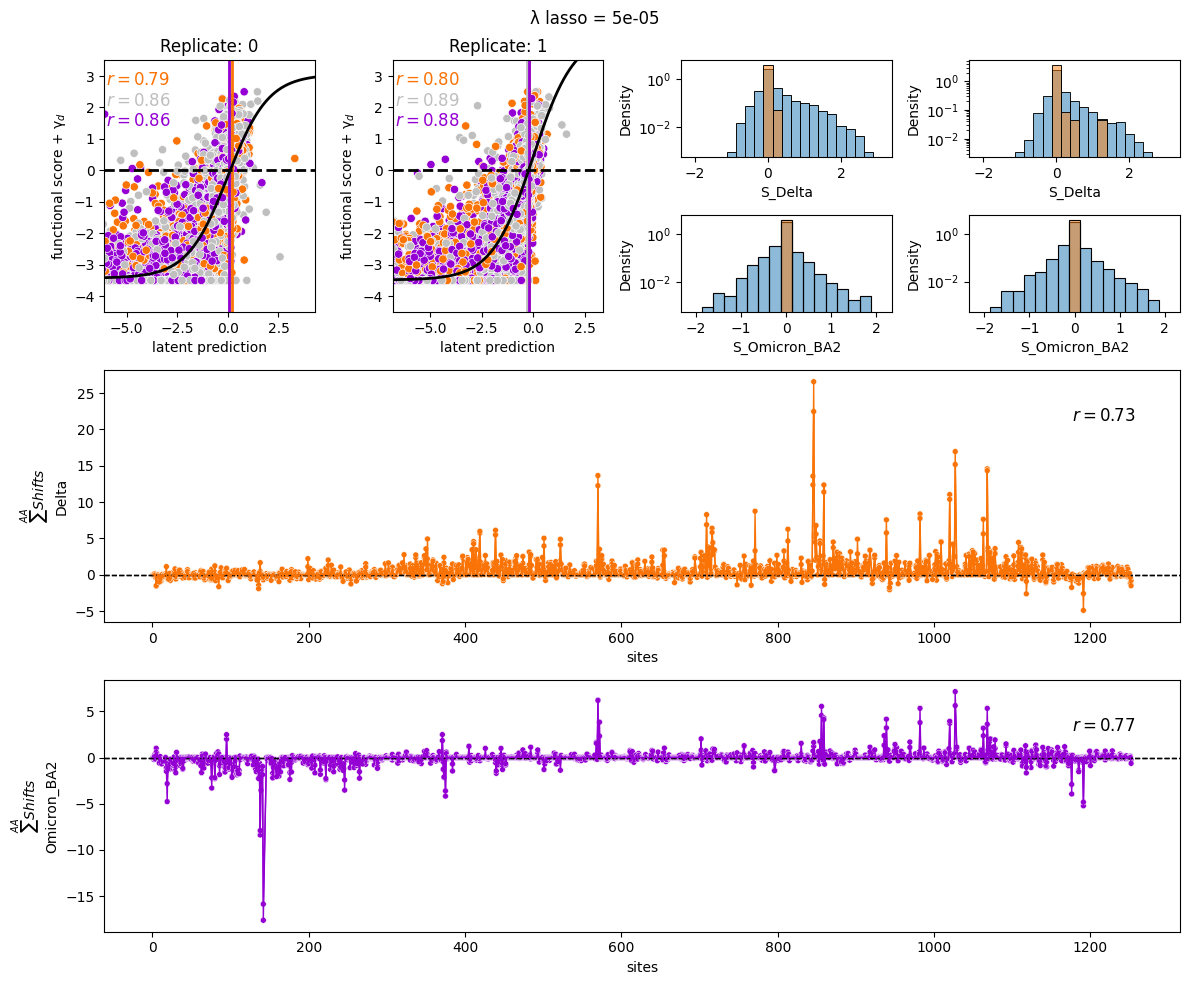

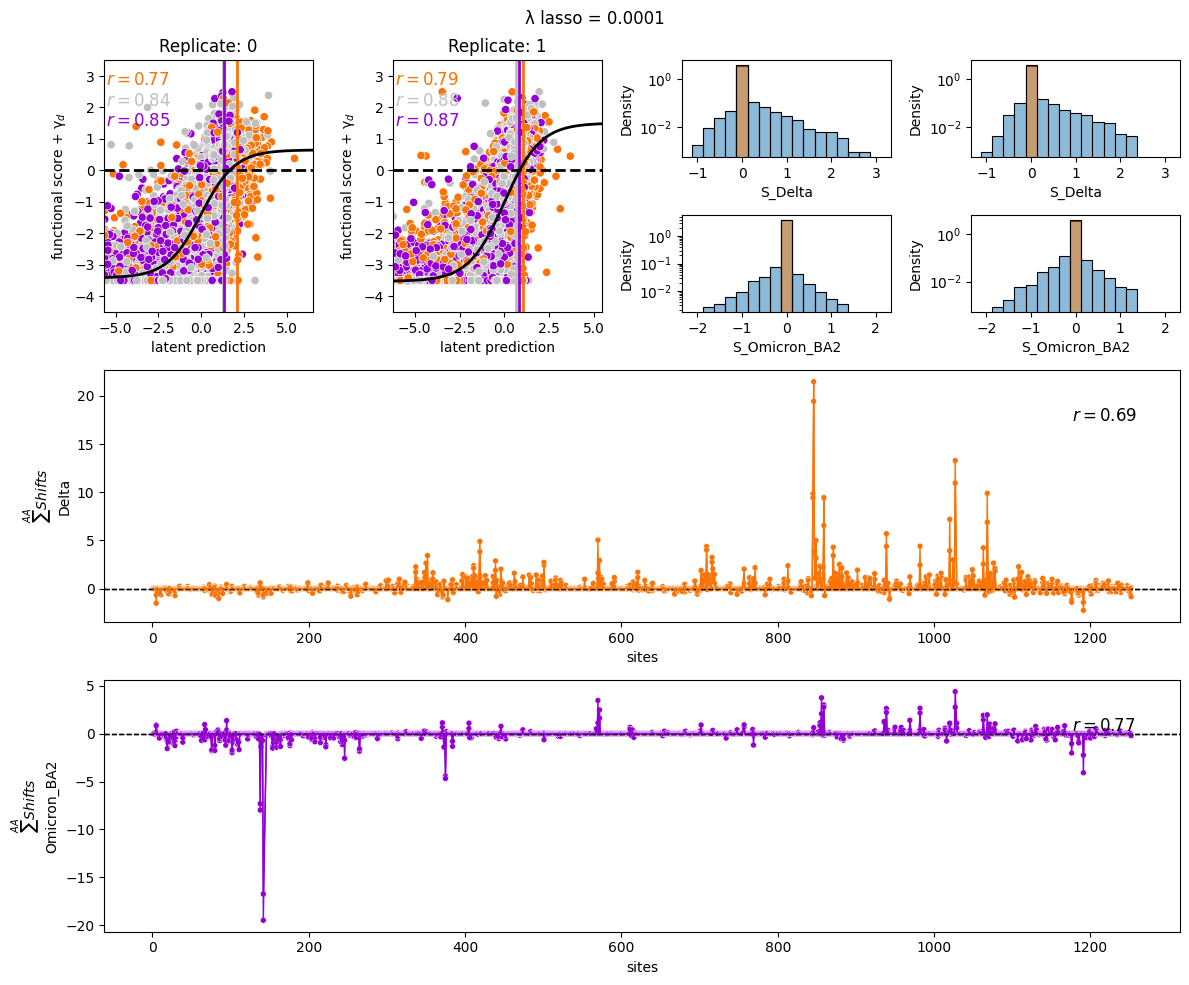

In [22]:
hist_ax_map = {
    "Delta-0" : "A",
    "Delta-1" : "B",
    "Omicron_BA2-0" : "C",
    "Omicron_BA2-1" : "D"
}
site_ax_map = {
    "Delta" : "d",
    "Omicron_BA2" : "o"
}


for i, (lasso, lasso_replicates) in enumerate(models.groupby("λ_lasso_shift")):
    if not (lasso == 5e-5 or lasso == 1e-4 or lasso == 2e-5): continue
#     if lasso != 1e-4: continue
        
    i=0
    fig, ax = plt.subplot_mosaic(
        """
        01AB
        01CD
        dddd
        dddd
        oooo
        oooo
        """,
        figsize=[12,10]
    )
#     ax[f"S"].set_ylim([-20, 20])
    
    fit_dict = {}
    for _, row in lasso_replicates.iterrows():
        replicate = row.replicate
        model = row[model_name]
        fit_dict[f"{replicate}"] = model
        
        # epistasis and accuracy
        model.plot_epistasis(show=False, ax=ax[str(replicate)], sample=0.1, legend=False)
        ax[str(replicate)].set_xlabel("latent prediction")
        ax[str(replicate)].set_title(f"Replicate: {replicate}")
        var_df = model.variants_df
        
        for b, cond in enumerate(model.data.conditions):
            var_df_cond = var_df.query(f"condition == @cond")
            corr = pearsonr(
                var_df_cond["predicted_func_score"], 
                var_df_cond["corrected_func_score"] 
            )[0]
            ax[str(replicate)].annotate(
                f"$r = {corr:.2f}$", 
                (0.01, (0.90 - (b*0.08))), 
                xycoords="axes fraction", 
                fontsize=12,
                c = model.data.condition_colors[cond]
            )
            
            if cond == model.data.reference: continue
            model.plot_shifts_by_site(
                cond, 
                show=False, 
                agg_func=np.sum, 
                times_seen_threshold=3, 
                ax=ax[site_ax_map[cond]], 
                lw=1
            )
            ax[site_ax_map[cond]].set_ylabel("$\sum^{AA} Shifts$"+"\n"+cond)

    muts_df_outer = multidms.utils.combine_replicate_muts(fit_dict, times_seen_threshold=3, how="outer")
    muts_df_inner = muts_df_outer.dropna()
    
    
    
    
    for b, cond in enumerate(model.data.conditions):
        if cond == model.data.reference: continue 
        corr = pearsonr(muts_df_inner[f"0_S_{cond}"], muts_df_inner[f"1_S_{cond}"])[0]
        ax[site_ax_map[cond]].annotate(
            f"$r = {corr:.2f}$", 
            (0.9, 0.8), 
            xycoords="axes fraction", 
            fontsize=12,
#             c = model.data.condition_colors[cond]
        )
        
#         ax[f"S"].annotate(
#             cond, 
#             (0.01, (0.90 - (b*0.06))), 
#             xycoords="axes fraction", 
#             fontsize=12,
#             c = model.data.condition_colors[cond]
#         )
        
#     ax[f"S"].set_ylabel("$\sum^{AA} Shifts$")
    
    for _, row in lasso_replicates.iterrows():
        replicate = row.replicate
        model = row[model_name]
        for b, cond in enumerate(model.data.conditions):
            if cond == model.data.reference: continue   
            axes = ax[hist_ax_map[f"{cond}-{replicate}"]]
            model.plot_param_hist(f"S_{cond}",show=False, ax=axes)
            axes.set_yscale("log")
        
    
#     muts_df_outer = muts_df_outer[
#         [c for c in muts_df_outer.columns if "S_" in c and "avg" not in c]
#     ]
#     muts_df_outer.rename(
#         {
#             "0_S_Omicron_BA2":"BA2 (1)", 
#             "1_S_Omicron_BA2":"BA2 (2)",
#             "0_S_Delta":"Delta (1)",
#             "1_S_Delta":"Delta (2)"
#         },
#         axis=1,
#         inplace=True
#     )
#     muts_df_outer = muts_df_outer.assign(
#         is_stop=[
#             "stop" if "*" in m else "non-stop" 
#             for m in muts_df_outer.index.values
#         ]
#     )
#     melted_mut_df = pd.melt(muts_df_outer.reset_index(), id_vars=["mutation", "is_stop"])
#     sns.violinplot(
#         melted_mut_df, 
#         x="variable", 
#         y="value", 
#         hue="is_stop", 
#         ax = ax[f"D"],
#         split=True
#     )

#     ax[f"D"].legend(bbox_to_anchor=(1.00, 1), borderaxespad=0, frameon=False)

        
#     for os, (cond, cond_df) in enumerate(melted_mut_df.groupby("variable")):
#         exact_sparsity = len(cond_df[cond_df['value'] == 0]) / len(cond_df)
# #         close_sparsity = len(cond_df[onp.isclose(cond_df['value'], 0)]) / len(cond_df)
        
#         ax[f"D"].annotate(f"==0    : {round(exact_sparsity, 3)}", (os-0.3, -4))
# #         ax[f"D"].annotate(f"<=1e-8 : {round(close_sparsity, 3)}", (os-0.3, -4.7))
        
    
#     ax["D"].legend(bbox_to_anchor=(1.00, 1), borderaxespad=0, frameon=False)
    
    fig.suptitle(f"λ lasso = {lasso}")
    plt.tight_layout()
#     fig.savefig(f"ch-nogamma-summary-{lasso}.pdf")
    fig.savefig(f"{OUTDIR}/lasso_{lasso}.pdf")
    
    plt.show()

In [24]:
fit_dict = {row.replicate:row.model_20000 for _, row in models.query("λ_lasso_shift == 5e-5").iterrows()}
mut_df = multidms.utils.combine_replicate_muts(fit_dict, times_seen_threshold=3, how="inner")
mut_df

,wts,sites,muts,0_β,1_β,avg_β,0_S_Delta,1_S_Delta,avg_S_Delta,0_S_Omicron_BA2,1_S_Omicron_BA2,avg_S_Omicron_BA2
mutation,,,,,,,,,,,,
M1I,M,1,I,-3.065622,-4.007648,-3.536635,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
F2L,F,2,L,0.210662,0.260825,0.235744,-0.000000,-0.000000,0.000000,-0.202946,0.000000,-0.101473
V3A,V,3,A,-0.038798,-0.049182,-0.043990,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000
V3F,V,3,F,-0.316701,-0.240966,-0.278834,-0.000000,-0.000000,0.000000,-0.000000,0.008371,0.004186
V3G,V,3,G,0.005484,0.052085,0.028785,0.000000,0.000000,0.000000,0.000000,-0.004430,-0.002215
...,...,...,...,...,...,...,...,...,...,...,...,...
S1252R,S,1252,R,0.138523,0.217186,0.177855,-0.024803,-0.000000,-0.012401,0.078496,0.000000,0.039248
S1252T,S,1252,T,-0.158840,-0.219188,-0.189014,-0.000000,0.000000,0.000000,-0.060251,-0.000000,-0.030126
S1252V,S,1252,V,0.192696,0.216603,0.204649,0.342725,-0.217827,0.062449,-0.040749,-0.130770,-0.085760


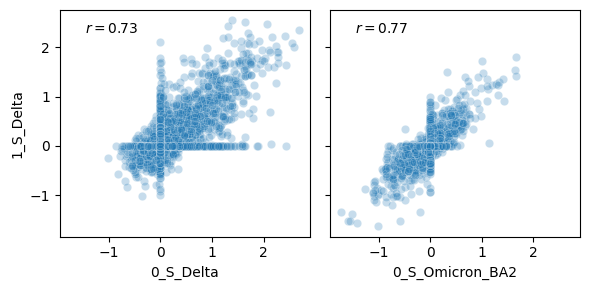

In [30]:
import seaborn as sns
fig, ax = plt.subplots(1,2, figsize=[6,3], sharex=True, sharey=True)
# ax.axhline(0, color="k", ls="--", lw=1)
for i, condition in enumerate(["Delta", "Omicron_BA2"]):
    corr = pearsonr(mut_df[f"0_S_{condition}"], mut_df[f"1_S_{condition}"])[0]
    sns.scatterplot(mut_df, x=f"0_S_{condition}", y=f"1_S_{condition}", ax=ax[i], alpha=0.25)
    ax[i].annotate(
        f"$r = {corr:.2f}$", 
        (0.1, 0.9), 
        xycoords="axes fraction", 
        fontsize=10
    )
plt.tight_layout()
plt.show()

In [20]:
# # Read in data
# titers_df = pd.read_csv('../data/viral_titers.csv')
# titers_df.rename(
#     columns={'RLUperuL':'titer', 'background':'homolog'},
#     inplace=True
# )

# # Add a column giving the replicate and mutation
# titers_df['replicate'] = titers_df['virus'].apply(lambda x: x[-1])
# titers_df['mutation'] = titers_df['virus'].str.extract(r'_(\S+)_')
# titers_df['mutation'].fillna('unmutated', inplace=True)
# titers_df['mutation'].replace('142L', 'D142L', inplace=True)

# # Plot data for a given mutation
# validation_mutations = ['D142L', 'A419S', 'A570D', 'K854N', 'T1027I']
# #mutation = 'A570D'
# homologs = ['Delta', 'BA.1', 'BA.2']
# replicates = ['1', '2', '3']
# plt.figure(figsize=[7,4])
# xticklabels = ['unmutated'] + validation_mutations
# pal = sns.color_palette('colorblind')
# hex_codes = pal.as_hex()
# for (i, homolog) in enumerate(homologs):
    
#     data = titers_df[(titers_df['homolog'] == homolog)]
    
#     sns.stripplot(
#         x='mutation', y='titer', data=data,
#         order=xticklabels, s=15, alpha=0.5,
#         hue='homolog', hue_order=['Delta', 'BA.1', 'BA.2'],
#     )
#     sns.boxplot(
#         x='mutation', y='titer', data=data,
#         order=xticklabels,
#         showfliers=False, showbox=False, showcaps=False,
#         medianprops=dict(color=hex_codes[i]),
#         whiskerprops={'visible': False},
#     )
# #     axs[i].set(
# #         title=homolog, yscale='log', yticks=[1e2, 1e4, 1e6],
# #         ylabel=r'viral titer (RLU/$\mu$L)', xlabel='',
# #     )
# #     axs[i].set_xticklabels(xticklabels, rotation=90)
# #     axs[i].grid()
# #     axs[i].get_legend().remove()
# #plt.set_xticklabels(xticklabels, rotation=90)

# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=[1,1])

# plt.yscale('log')
# plt.yticks([1e2, 1e4, 1e6])
# plt.xticks(rotation=90)
# plt.ylabel(r'viral titer (RLU/$\mu$L)')
# plt.xlabel('')
# plt.grid()
# sns.despine()
# plt.tight_layout()
# plt.show()

/tmp/ipykernel_7206/3191404340.py:48: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  predicted_beta = float(mut_df[


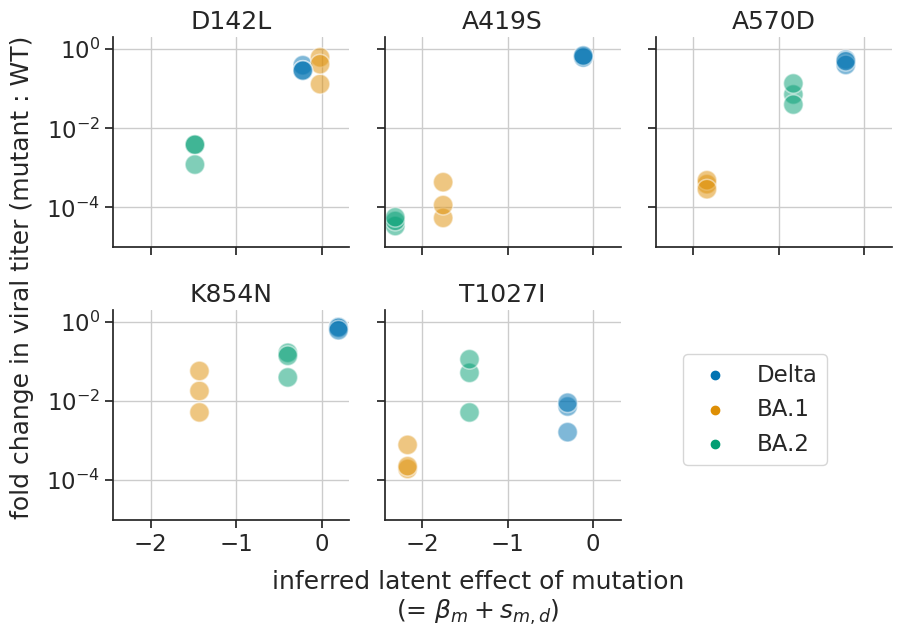

/tmp/ipykernel_7206/3191404340.py:48: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  predicted_beta = float(mut_df[


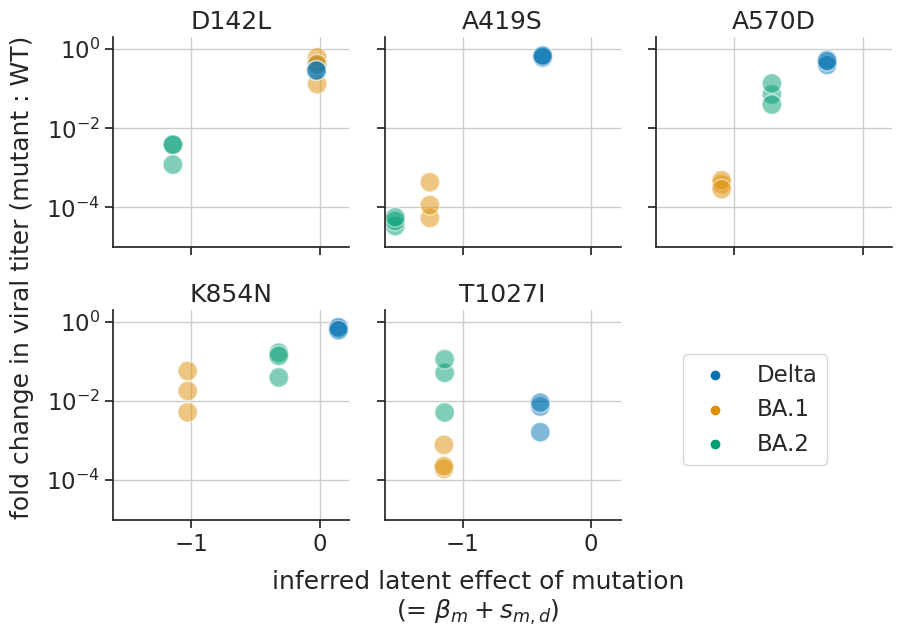

/tmp/ipykernel_7206/3191404340.py:48: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  predicted_beta = float(mut_df[


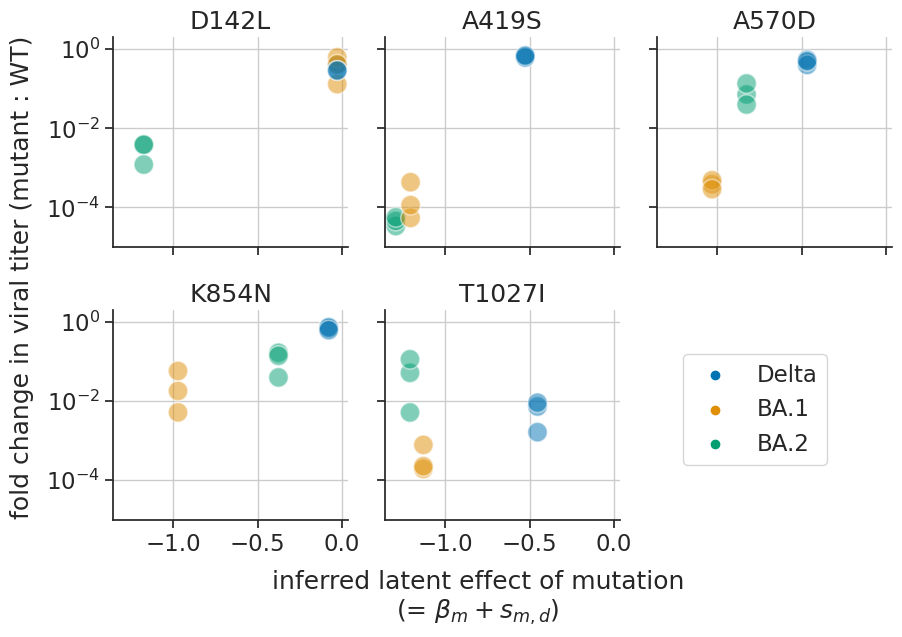

In [21]:
# chosen_lasso_strength = 2e-5

import seaborn as sns
sns.set_theme(font_scale=1.5, style='ticks', palette='colorblind')


for chosen_lasso_strength in [2e-5, 5e-5, 1e-4]:
    replicate_models = models.query("λ_lasso_shift == @chosen_lasso_strength")
    fit_dict = {row.replicate:row[model_name] for _, row in replicate_models.iterrows()}
    mut_df = multidms.utils.combine_replicate_muts(fit_dict, times_seen_threshold=3, how="inner")

    rep0 = fit_dict[0]
    for homolog in rep0.data.conditions:
        if homolog == rep0.data.reference:

            mut_df[f"β_{homolog}"] = mut_df.avg_β
        else:

            mut_df[f"β_{homolog}"] = mut_df.avg_β + mut_df[f"avg_S_{homolog}"]

    mut_df.reset_index(inplace=True)

    # Read in data
    val_df = pd.read_csv('../data/spike_validation_data.csv')

    # Restructure the data
    val_dict = {
        key : []
        for key in [
            'mutation', 'fold_change', 'homolog', 'replicate',
            'predicted_beta'
        ]
    }
    validation_mutations = ['D142L', 'A419S', 'A570D', 'K854N', 'T1027I']
    for i, row in val_df.iterrows():
        for mutation in validation_mutations:
            homolog = row['background'].replace('.', '')
            homolog = "Omicron_" + homolog if "BA" in homolog else homolog
    #         print(homolog)
            val_dict['mutation'].append(mutation)
            val_dict['fold_change'].append(row[mutation])
            val_dict['homolog'].append(homolog)
            val_dict['replicate'].append(row['replicate'])

    #         predicted_beta = float(mut_df[
    #             mut_df['mutation'] == mutation
    #         ][f'β_{homolog}'])
            predicted_beta = float(mut_df[
                mut_df['mutation'] == mutation
            ][f'β_{homolog}'])
            val_dict['predicted_beta'].append(predicted_beta)

    val_df = pd.DataFrame(val_dict)
    val_df['site'] = val_df['mutation'].apply(lambda x: int(x[1:-1]))
    val_df['homolog'].replace('Omicron_BA1', 'BA.1', inplace=True)
    val_df['homolog'].replace('Omicron_BA2', 'BA.2', inplace=True)
    val_df.sort_values('site', inplace=True)
    # val_df.head()

    (fig, axs) = plt.subplots(
        nrows=2, ncols=3, sharex=True, sharey=True,
        figsize=[9,6]
    )
    axs = axs.reshape(-1)

    for (i, mutation) in enumerate(validation_mutations):
        data = val_df[val_df['mutation'] == mutation]
        sns.scatterplot(
            x='predicted_beta', y='fold_change', data=data,
            hue='homolog', ax=axs[i], s=200, alpha=0.5,
            hue_order=['Delta', 'BA.1', 'BA.2']
        )
        axs[i].set(
            title=mutation, xlabel='', ylabel='',
            yscale='log', ylim=[1e-5,2], yticks=[1, 1e-2, 1e-4]
        )
        axs[i].grid()
        axs[i].get_legend().remove()

    fig.text(
        0.51, -0.06, 'inferred latent effect of mutation\n(= $β_m + s_{m,d}$)',
        ha='center'
    )
    fig.text(
        -0.01, 0.51, 'fold change in viral titer (mutant : WT)',
        va='center', rotation='vertical'
    )
    #axs[0].set(ylabel='observed fold change\n(validation experiment)')
    #axs[1].legend(loc='lower right')
    axs[5].set_visible(False)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=[0.91,0.4])
    plt.tight_layout()
    sns.despine()
    plt.show()
    fig.savefig(f"{OUTDIR}/validation_{chosen_lasso_strength}.pdf")
